# 4. Model Selection - Sales Forecast

## Contents
- 4.1 [Introduction](#3.1Introduction)
- 4.2 [Import, Load, Explore](#3.2-Import,Load,Explore)
   - 4.2.1 [Loading datasets](#4.2.1.Loading) 
- 4.3 [Initial exploration](#4.3.InitialExploration)
- 4.4 [Model Selection](#4.4.ModelSelection)
   - 4.4.1 [ARIMA model](#4.4.1.ARIMA)
   - 4.4.2 [Prophet](#4.4.2.Prophet)
   - 4.4.3 [LSTM](#4.4.3.LSTM) 
- 4.5 [Summary](#4.5.Summary)


## 4.1 Introduction <a id="3.1Introduction"></a>
In this phase, I'll explore 3 different models to forecast, after evaluating each model, the final model will be selected. 

## 4.2 Install & Import packages<a id="3.2-Import,Load,Explore"></a>


In [1]:
%%capture

!pip install pmdarima
!pip install Cython
!pip install pystan==2.19.1.1
!pip install prophet
!pip install tensorflow

In [2]:
#Importing relevant libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint 

from tensorflow.keras.losses import MeanSquaredError 
from tensorflow.keras.metrics import RootMeanSquaredError 

### 4.2.1 Loading datasets  <a id="4.2.1.Loading"></a>

In [3]:
#Loading training data

train_data = pd.read_csv("train_forecast.csv")
train_data

,WeekStartDate,Category,CustomerPerCategory,Quantity
0,2011-01-10,-1,40157996,10631
1,2011-01-10,0,67721767,31979
2,2011-01-10,1,21306812,9312
3,2011-01-10,2,19201996,7546
4,2011-01-10,3,66576,96
...,...,...,...,...
559,2011-09-26,3,66576,323
560,2011-09-26,4,4880319,3336
561,2011-09-26,5,42234410,11849
562,2011-09-26,6,7048658,3023


In [4]:
train_data.shape

(564, 4)

In [5]:
train_data['WeekStartDate'] = pd.to_datetime(train_data['WeekStartDate'])

In [6]:
#Loading testing data
test_data = pd.read_csv("test_forecast.csv", parse_dates=['WeekStartDate'])
print(test_data.shape)
#Spliting into testing and validation data
val_data = test_data.iloc[:-70]
test_data = test_data.iloc[-70:]
val_data.shape, test_data.shape

(141, 4)


((71, 4), (70, 4))

In [7]:
train_data = train_data.set_index('WeekStartDate')
test_data = test_data.set_index('WeekStartDate')
val_data = val_data.set_index('WeekStartDate')

In [8]:
# subseting records of Category 0 validation data and test data.
Category_0_train = train_data[train_data['Category'] == 0]
Category_0_val = val_data[val_data['Category'] == 0]
Category_0_test = test_data[test_data['Category'] == 0]

## 4.3 Initial exploration <a id="4.3.InitialExploration"></a>

<Figure size 1200x600 with 0 Axes>

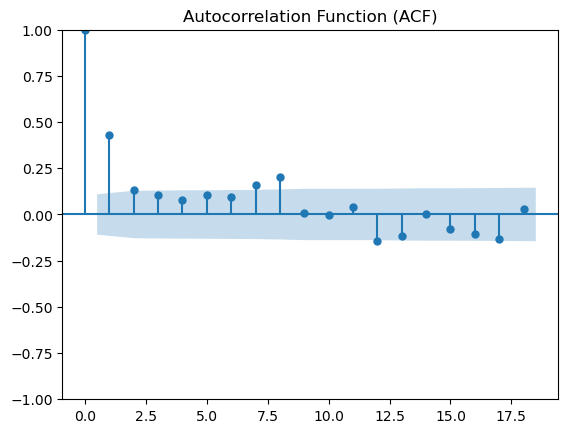

<Figure size 1200x600 with 0 Axes>

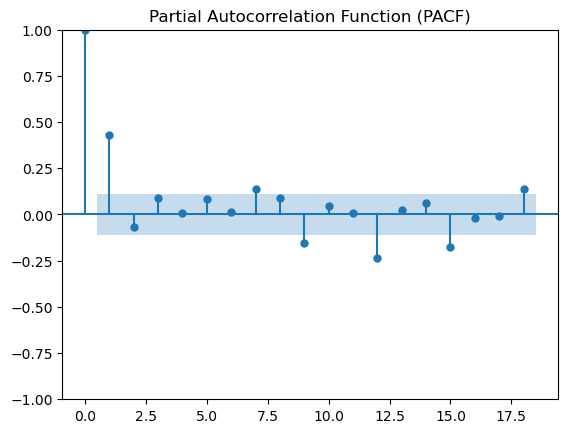

In [9]:
plt.figure(figsize=(12, 6))
plot_acf(Category_0_train['Quantity'], lags=18, alpha = 0.5)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(Category_0_train['Quantity'], lags=18, alpha = 0.5)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [10]:
#checking for stationarity

def ad_test(data):
    result = adfuller(data, autolag = 'AIC')
    print('ADF: ', result[0])
    print('p-value: ', result[1])
    print('Num of lags: ', result[2])
    print('Num of observations used:', result[3])
    print('Critical values: ')
    for key, val in result[4].items():
        print(key, ":", val)

In [11]:
ad_test(Category_0_train['Quantity'])

ADF:  -3.390855238564071
p-value:  0.01127459436346096
Num of lags:  0
Num of observations used: 37
Critical values: 
1% : -3.6209175221605827
5% : -2.9435394610388332
10% : -2.6104002410518627


since the 
p-value for quantity is lower than 0.05, we can conclude that the quuantity data for Category 0 is stationary, no need for differencing.

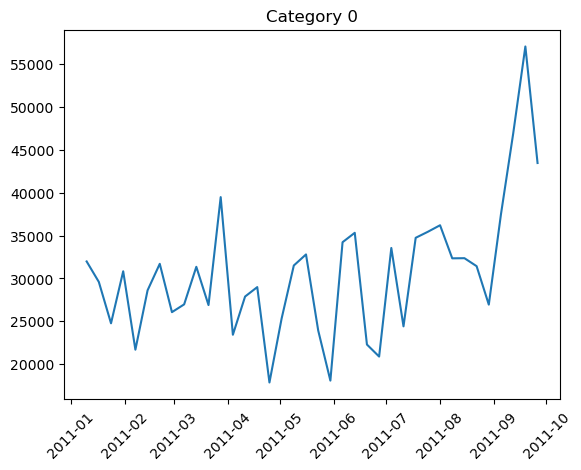

In [12]:
plt.plot(Category_0_train['Quantity'])
plt.title('Category 0')
plt.xticks(rotation = 45)
plt.show()

In [13]:
stepwise_fit = auto_arima(Category_0_train['Quantity'],
                         trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=769.914, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=773.819, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=771.891, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=766.816, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=771.888, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=769.051, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=770.549, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=767.871, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=766.108, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=766.953, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=766.406, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=770.222, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=767.522, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.662 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -381.054
Date:                Mon, 29 Jan 2024   AIC                            766.108
Time:                        15:46:18   BIC                            769.330
Sample:                    01-10-2011   HQIC                           767.244
                         - 09-26-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5712      0.131     -4.359      0.000      -0.828      -0.314
sigma2      5.324e+07   6.11e-10   8.71e+16      0.000    5.32e+07    5.32e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.87   Prob(JB):                         0.65
Heteroskedasticity (H):               1.53   Skew:                             0.16
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+33. Standard errors may be unstable.
"""

##  4.4 Model Selection <a id="4.4.ModelSelection"></a>

### 4.4.1 ARIMA model <a id="4.4.1.ARIMA"></a>

In [14]:
model_ARIMA = ARIMA(Category_0_train['Quantity'], order = (0,1,1))
results_ARIMA = model_ARIMA.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                   38
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -381.054
Date:                Mon, 29 Jan 2024   AIC                            766.108
Time:                        15:46:18   BIC                            769.330
Sample:                    01-10-2011   HQIC                           767.244
                         - 09-26-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5712      0.131     -4.359      0.000      -0.828      -0.314
sigma2      5.324e+07   6.11e-10   8.71e+16      0.000    5.32e+07    5.32e+07
Ljung-Box (L1) (Q):                   0.03   Jarque-

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [15]:
# Evaluating the ARIMA model

start_date = Category_0_val.index[0]
end_date = Category_0_val.index[-1] 

In [16]:
pred = results_ARIMA.predict(start = start_date, end = end_date)

<Axes: xlabel='WeekStartDate'>

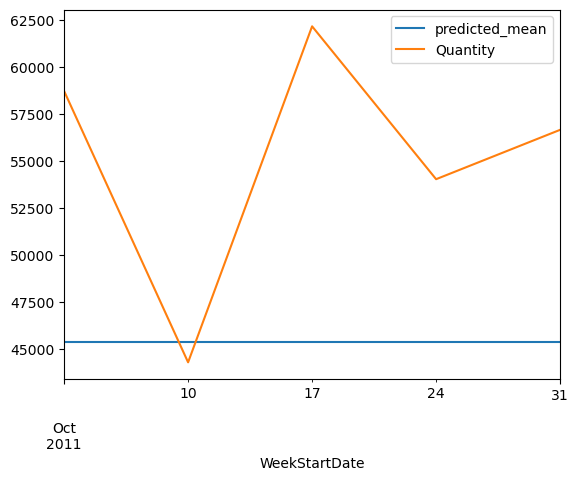

In [17]:
pred.plot(legend = True)
Category_0_val['Quantity'].plot(legend = True)

In [18]:
residuals = Category_0_val['Quantity'] - pred

In [19]:
#Evaluating the model

# MAE
mae = mean_absolute_error(Category_0_val['Quantity'], pred)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(Category_0_val['Quantity'], pred)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((Category_0_val['Quantity']- pred) / Category_0_val['Quantity'])) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 10228.35
MSE: 132598576.0
RMSE: 11515.15
MAPE: 17.62%


### 4.4.2 Prophet model <a id="4.4.2.Prophet"></a>

In [20]:
train = pd.DataFrame({
    'ds': Category_0_train.index,
    'y': Category_0_train['Quantity']
})

In [21]:
m = Prophet(changepoint_prior_scale=0.5)
prophet_model = m.fit(train)


15:46:19 - cmdstanpy - INFO - Chain [1] start processing
15:46:19 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
#Prediction

future = m.make_future_dataframe(periods = 5 , freq = 'W')
forecast = m.predict(future)

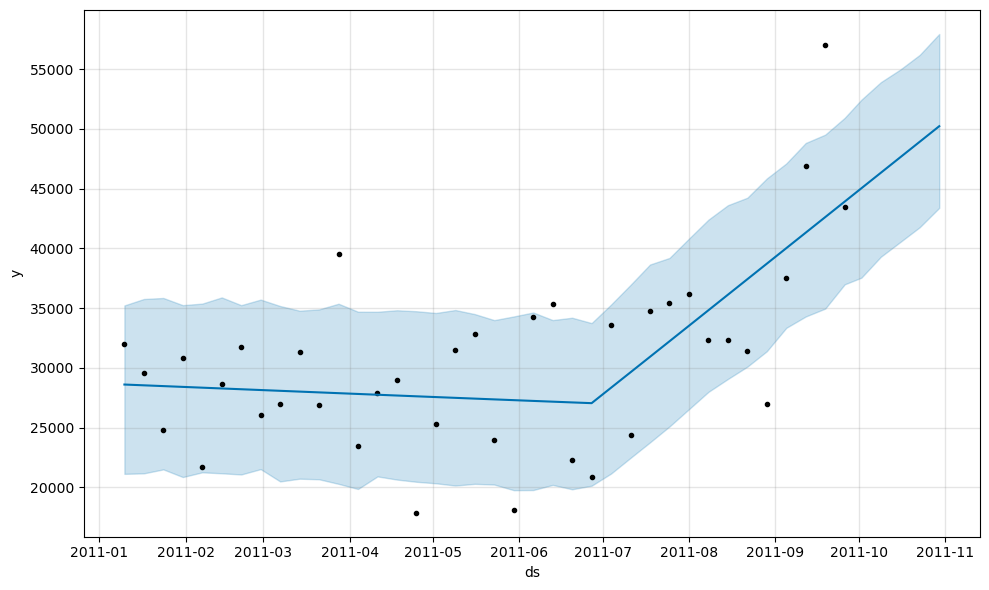

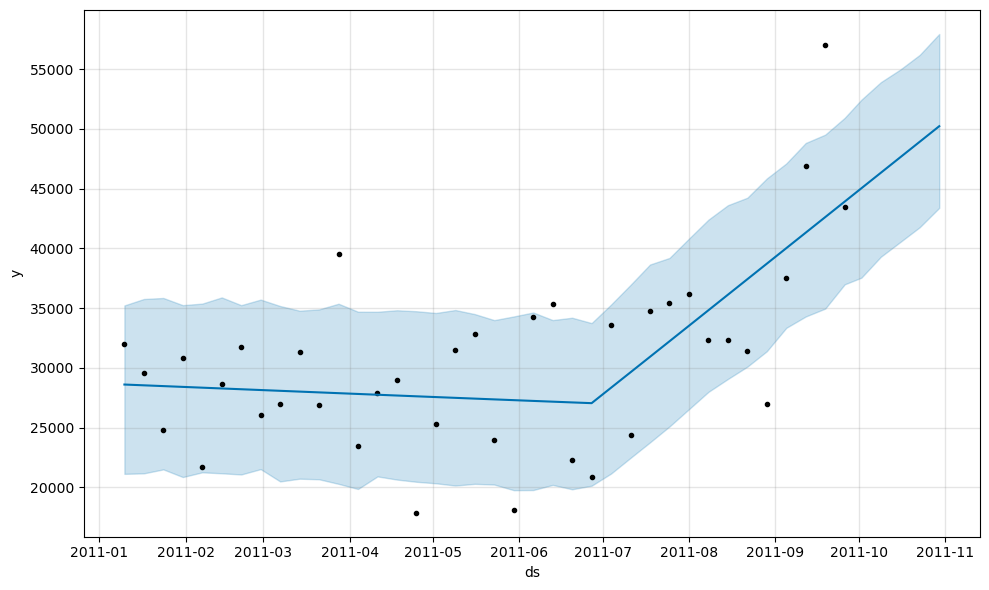

In [23]:
m.plot(forecast)

In [24]:
predicted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-5:]
predicted

,ds,yhat,yhat_lower,yhat_upper
38,2011-10-02,45019.604094,37537.127430,52433.165824
39,2011-10-09,46318.686160,39289.636069,53899.417912
40,2011-10-16,47617.768225,40524.805179,54959.096636
41,2011-10-23,48916.850290,41764.658151,56188.457162
42,2011-10-30,50215.932355,43381.503387,57935.779689


In [25]:
predicted_p = predicted[['ds', 'yhat']].set_index('ds')

<Axes: xlabel='WeekStartDate'>

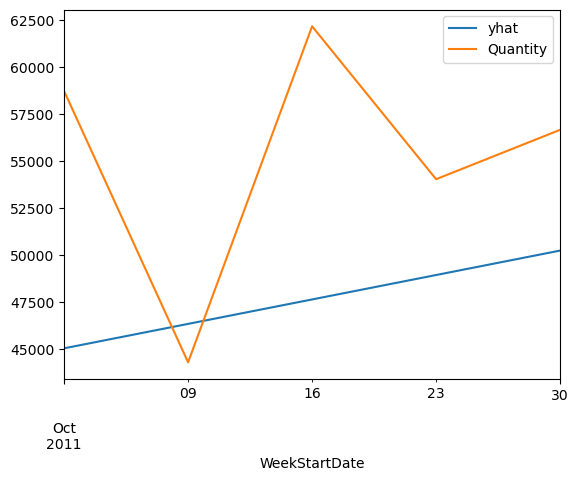

In [26]:
predicted_p['yhat'].plot(legend = True)
Category_0_val['Quantity'].plot(legend = True)

In [27]:
#Evaluating the model

# MAE
mae = mean_absolute_error(Category_0_val['Quantity'], predicted['yhat'].values)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(Category_0_val['Quantity'], predicted['yhat'].values)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((Category_0_val['Quantity']- predicted['yhat'].values) / Category_0_val['Quantity'])) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 8352.31
MSE: 93880584.02
RMSE: 9689.2
MAPE: 14.41%


### 4.4.3 LSTM <a id="4.4.3.LSTM"></a>

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(Category_0_train['Quantity'].values.reshape(-1, 1) )

val_scaled = scaler.fit_transform(Category_0_val['Quantity'].values.reshape(-1, 1) )

test_scaled = scaler.fit_transform(Category_0_test['Quantity'].values.reshape(-1, 1) )

In [29]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [30]:
X, y = create_sequences(train_scaled, 1)

X = X.reshape((X.shape[0], X.shape[1], 1))

In [31]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(64, input_shape=(X.shape[1], 1)))
model_LSTM.add(Dense(1, activation='relu'))
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(32, return_sequences = True, input_shape=(X.shape[1], 1)))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(12, return_sequences = True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(6, return_sequences = True))
model_LSTM.add(Dropout(0.2))


model_LSTM.add(Dense(1))
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 32)             4352      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 12)             2160      
                                                                 
 dropout_1 (Dropout)         (None, 1, 12)             0         
                                                                 
 lstm_3 (LSTM)               (None, 1, 6)              456       
                                                                 
 dropout_2 (Dropout)         (None, 1, 6)              0         
                                                                 
 dense_1 (Dense)             (None, 1, 1)             

In [34]:
model_LSTM.fit(X, y, epochs = 50, batch_size = 10)

Epoch 1/50

4/4 [==============================] - 10s 11ms/step - loss: 0.1433
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 0.1381
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 0.1321
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 0.1277
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 0.1215
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 0.1167
Epoch 7/50
4/4 [==============================] - 0s 7ms/step - loss: 0.1150
Epoch 8/50
4/4 [==============================] - 0s 8ms/step - loss: 0.1081
Epoch 9/50
4/4 [==============================] - 0s 9ms/step - loss: 0.1037
Epoch 10/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0976
Epoch 11/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0905
Epoch 12/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0823
Epoch 13/50
4/4 [==============================] - 0s 20ms/step - loss

In [35]:
def create_sequences_val(data, seq_length):
    sequences, targets = [], []
    for i in range(abs(len(data) - seq_length + 1)):
        seq = data[i:i + seq_length]
        target = data[i + seq_length - 1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)



In [36]:
X_val, y_val  = create_sequences(val_scaled, 1)

In [37]:
loss = model_LSTM.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")

1/1 [==============================] - 2s 2s/step - loss: 0.2112
Validation Loss: 0.21115106344223022


In [38]:
predictions = model_LSTM.predict(X_val)

1/1 [==============================] - 2s 2s/step


In [39]:
predictions_reshaped = predictions.reshape(-1, 1)

predictions_original_scale = scaler.inverse_transform(predictions_reshaped)

In [40]:
predictions_original_scale = scaler.inverse_transform(predictions_reshaped)


compare_df = pd.DataFrame({'Actual': scaler.inverse_transform(y_val.reshape(-1, 1)).flatten(),
                            'Predicted': predictions_original_scale.flatten()})
print(compare_df)

         Actual     Predicted
0  30310.000000  45594.406250
1  68275.000000  39989.125000
2  51002.146935  47158.765625
3  56578.422334  43582.753906


In [41]:
actual_LSTM = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
pred_LSTM = predictions_original_scale.flatten()

In [42]:
pred_LSTM = pd.Series(pred_LSTM) 
actual_LSTM = pd.Series(actual_LSTM) 


<Axes: >

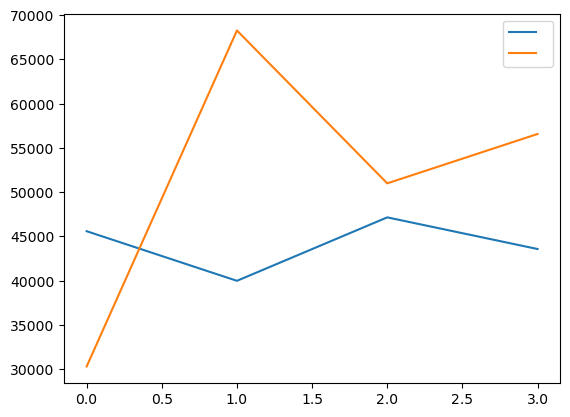

In [43]:
pred_LSTM.plot(legend = True)
actual_LSTM.plot(legend = True)

In [44]:
#Evaluating the model

# MAE
mae = mean_absolute_error(actual_LSTM, pred_LSTM.values)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(actual_LSTM, pred_LSTM.values)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((actual_LSTM- pred_LSTM.values) /actual_LSTM)) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 15102.33
MSE: 304340694.18
RMSE: 17445.36
MAPE: 30.59%


## 4.7 Summary <a id="4.5.Summary"></a>

In this stage, I experimented with three different forecasting models for a specific category of product sales data. When analyzing the data trend, it was observed to be stationary, and no differencing was necessary before fitting the ARIMA model. The ARIMA model yielded a Mean Absolute Percentage Error (MAPE) of 17.62%, which, while acceptable, has room for improvement.

Among the three models tested, the Prophet model proved to be the most effective and adaptable to the dataset, achieving a MAPE of 14.41%. On the other hand, the LSTM model performed less satisfactorily, primarily due to the limited dataset of 48 weeks and the complexity of tuning numerous hyperparameters.

Taking all factors into account, the Prophet model was ultimately chosen for the modeling phase.